In [12]:
import numpy as np
import pandas as pd
import imputation as imp
import forecasting as fc
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from codecarbon import EmissionsTracker
from eco2ai import Tracker

In [14]:
df = pd.read_csv("datasets/maxwell/household_data_60min.csv", index_col="utc_timestamp")
df = df.drop(columns=["cet_cest_timestamp"])
df = df.select_dtypes(include="number")
df.head()

,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,DE_KN_industrial3_area_room_1,DE_KN_industrial3_area_room_2,...,DE_KN_residential5_grid_import,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-11T17:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-11T18:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-11T19:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-11T20:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-11T21:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
prefixes = [
    "DE_KN_industrial1",
    "DE_KN_industrial2",
    "DE_KN_industrial3",
    "DE_KN_public1",
    "DE_KN_public2",
    "DE_KN_residential1",
    "DE_KN_residential2",
    "DE_KN_residential3",
    "DE_KN_residential4",
    "DE_KN_residential5",
    "DE_KN_residential6",
]

[codecarbon INFO @ 14:56:13] Energy consumed for RAM : 0.000486 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:56:13] Delta energy consumed for CPU with cpu_load : 0.000028 kWh, power : 7.041 W
[codecarbon INFO @ 14:56:13] Energy consumed for All CPU : 0.000343 kWh
[codecarbon INFO @ 14:56:13] 0.000829 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:56:14] Energy consumed for RAM : 0.000124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:56:14] Delta energy consumed for CPU with cpu_load : 0.000024 kWh, power : 5.9670000000000005 W
[codecarbon INFO @ 14:56:14] Energy consumed for All CPU : 0.000086 kWh
[codecarbon INFO @ 14:56:14] 0.000210 kWh of electricity used since the beginning.


In [ ]:
imputation_methods = {
    "LOCF": imp.locf,
    "NOCB": imp.nocb,
    "Linear Interpolation": imp.linear_interpolation,
    "Linear Regression": imp.linear_regression,
    "K-Nearest Neighbor": imp.knn,
    "MICE": imp.mice,
    "LightGBM": imp.lightgbm,
}


imputed = {}

for prefix in prefixes:
    cols = [col for col in df.columns if col.startswith(prefix)]
    target = prefix + "_grid_import"
    df_building = df[cols]
    df_masked, samples = imp.create_mcar_data(df_building, missing=0.2, seed=42)

    for n, f in imputation_methods.items():
        cc_tracker = EmissionsTracker(
            project_name=n,
            output_dir="performance/results",
            output_file="maxwell_codecarbon.csv",
        )
        eco_tracker = Tracker(project_name=n, file_name="performance/results/maxwell_eco2ai.csv")

        # Start time and emission trackers
        cc_tracker.start()
        eco_tracker.start()

        df_imputed = f(df_masked.copy())

        # Stop trackers
        emissions = cc_tracker.stop()
        eco_tracker.stop()

        # Store imputed data in dictionary
        imputed[(prefix, n)] = {
            "data": df_imputed,
            "target": target,
            "original": df_building,
            "samples": samples,
        }

        # Get error metrics only for the masked values
        i = df_building.columns.get_loc(target)
        mask = samples[:, i]
        y_true = df_building.values[:, i][mask]
        y_pred = df_imputed.values[:, i][mask]

        valid = (~np.isnan(y_true)) & (~np.isnan(y_pred))
        y_true = y_true[valid]
        y_pred = y_pred[valid]

        # Compute error
        mae = mean_absolute_error(y_true, y_pred)
        nrmse = root_mean_squared_error(y_true, y_pred) / (np.max(y_true) - np.min(y_true))

        r = pd.DataFrame(
            [
                {
                    "method": n,
                    "building": prefix,
                    "target": target,
                    "dataset": "genome",
                    "MAE": mae,
                    "NRMSE": nrmse,
                }
            ]
        )
        r.to_csv("performance/results/maxwell_performance.csv", mode="a", index=False, header=False)

[codecarbon WARNING @ 14:56:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:56:16] [setup] RAM Tracking...
[codecarbon INFO @ 14:56:16] [setup] CPU Tracking...


[codecarbon WARNING @ 14:56:17] We saw that you have a AMD Ryzen 5 7530U with Radeon Graphics but we don't know it. Please contact us.
[codecarbon WARNING @ 14:56:17] We will use the default power consumption of 4 W per thread for your 12 CPU, so 48W.
[codecarbon WARNING @ 14:56:17] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:56:17] CPU Model on constant consumption mode: AMD Ryzen 5 7530U with Radeon Graphics
[codecarbon WARNING @ 14:56:17] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 14:56:17] [setup] GPU Tracking...
[codecarbon INFO @ 14:56:17] No GPU found.
[codecarbon INFO @ 14:56:17] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: cpu_load
                GPU Tracking Method: Unspecified

[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 17180, number of used features: 6
[LightGBM] [Info] Start training from score 456.587851
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 11308, number of used features: 6
[LightGBM] [Info] Start training from score 45.736667
[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 12250, number of used features: 6
[LightGBM] [Info] Start training from score 100.689054
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 13315, number of used features: 6
[LightGBM] [Info] Start training from score 2178.736279
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 17246, number of used features: 6
[LightGBM] [Info] Start training from score 4215.027487
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 17

[codecarbon INFO @ 14:58:18] Energy consumed for RAM : 0.000007 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 11858, number of used features: 6
[LightGBM] [Info] Start training from score 38.401406


[codecarbon INFO @ 14:58:19] Delta energy consumed for CPU with cpu_load : 0.000007 kWh, power : 9.968 W
[codecarbon INFO @ 14:58:19] Energy consumed for All CPU : 0.000007 kWh
[codecarbon INFO @ 14:58:19] 0.000015 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.6861047744750977' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_d

[codecarbon INFO @ 14:58:28] Energy consumed for RAM : 0.000848 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:58:28] Delta energy consumed for CPU with cpu_load : 0.000036 kWh, power : 9.009000000000002 W
[codecarbon INFO @ 14:58:28] Energy consumed for All CPU : 0.000852 kWh
[codecarbon INFO @ 14:58:28] 0.001700 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:29] Energy consumed for RAM : 0.000486 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:58:29] Delta energy consumed for CPU with cpu_load : 0.000034 kWh, power : 8.442 W
[codecarbon INFO @ 14:58:29] Energy consumed for All CPU : 0.000602 kWh
[codecarbon INFO @ 14:58:29] 0.001088 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:43] Energy consumed for RAM : 0.000889 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:58:43] Delta energy consumed for CPU with cpu_load : 0.000022 kWh, power : 5.532000000000001 W
[codecarbon INFO @ 14:58:43] Energy consumed for All CPU : 0.000874 kWh
[codecarbon INF

[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 6
[LightGBM] [Info] Start training from score 3333.096923
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 6
[LightGBM] [Info] Start training from score 2946.544220
[LightGBM] [Info] Total Bins 1518
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 6
[LightGBM] [Info] Start training from score 3333.745304
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 6
[LightGBM] [Info] Start training from score 4211.671326
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 6
[LightGBM] [Info] Start training from score 4209.378982
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set

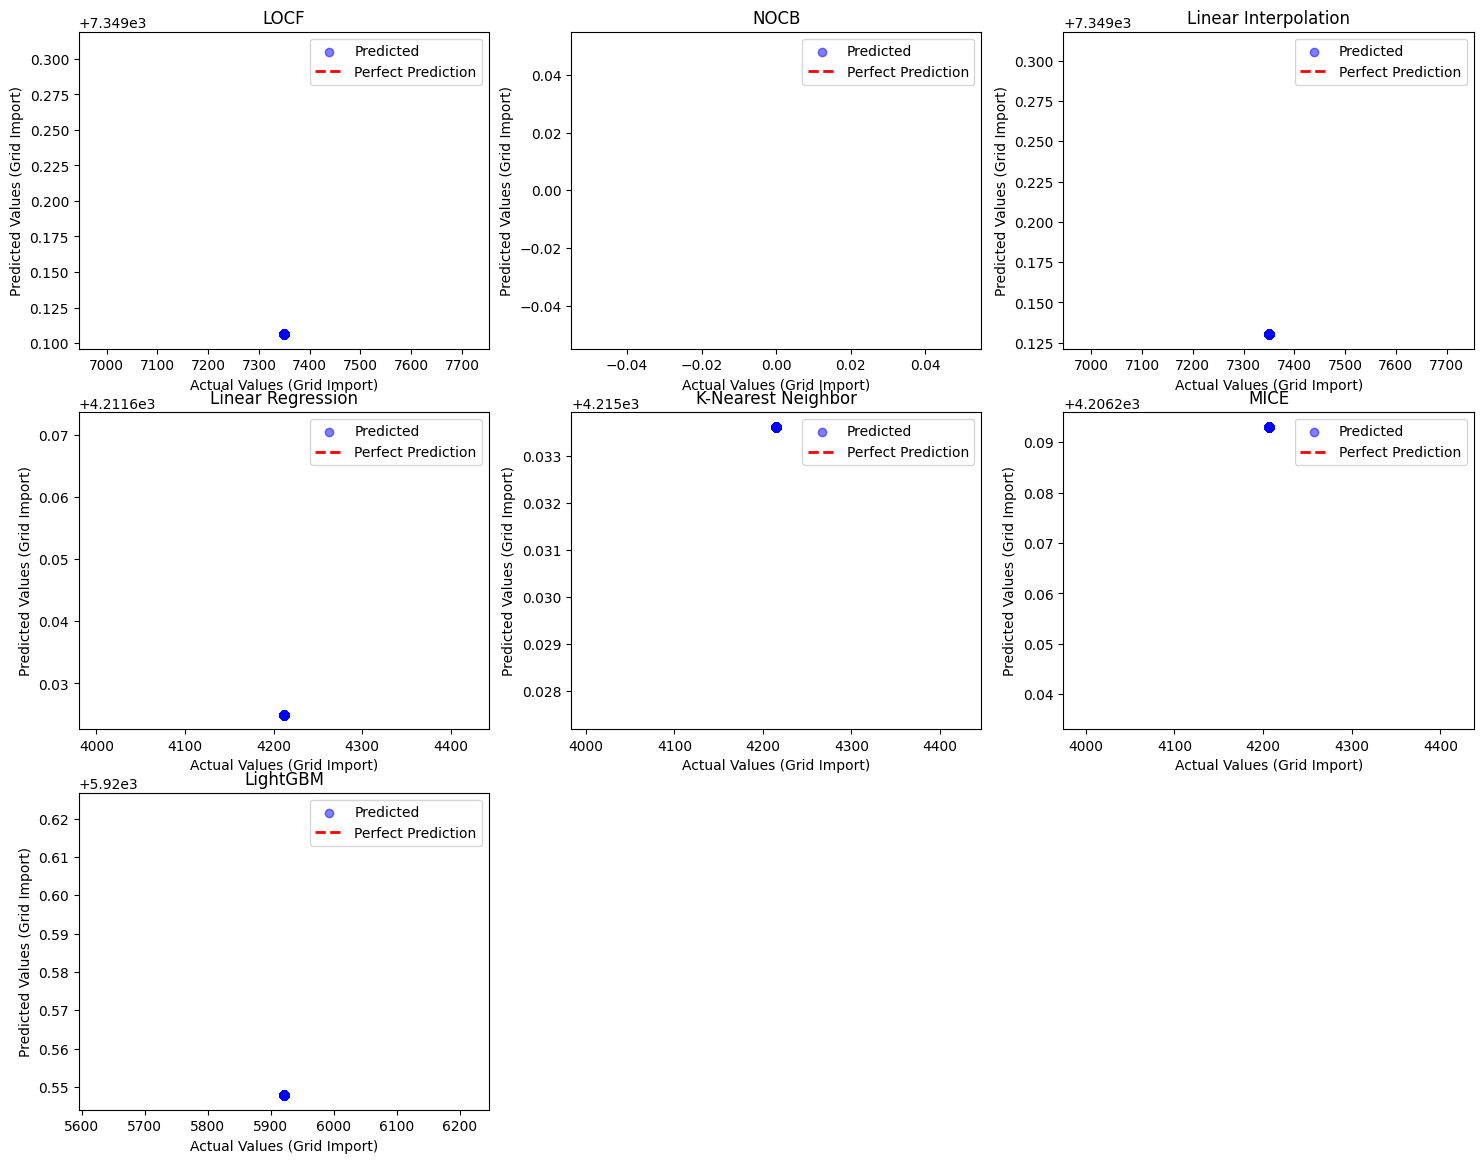

In [ ]:
features = [col for col in df_building.columns if col != target]
forecasting = {}

for i, ((building, name), d) in enumerate(imputed.items()):
    X = df_imputed[features]
    y = df_imputed[target]

    X_train, X_test, y_train, y_test = fc.split_data(X, y, train_size=0.8)

    model = LGBMRegressor(force_col_wise=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        valid = (~np.isnan(y_test)) & (~np.isnan(y_pred))
        mae = mean_absolute_error(y_test[valid], y_pred[valid])

        forecasting[(building, name)] = {
            "building": building,
            "method": name,
            "target": target,
            "MAE": mae,
            "dataset": "genome",
        }
    except:
        forecasting[name] = np.nan

df_forecasting = pd.DataFrame.from_dict(forecasting, orient="index").reset_index()
# df_forecasting.rename(columns={"level_0": "site", "level_1": "method"}, inplace=True)
df_forecasting.to_csv("performance/results/maxwell_forecasting.csv", index=False)

In [ ]:
# Save to CSV files for plotting later
df_performance = pd.DataFrame.from_dict(performance, orient="index")
df_performance["dataset"] = "maxwell"
df_performance.to_csv("performance/results/performance.csv", mode="a")

df_forecasting = pd.DataFrame.from_dict(forecasting, orient="index")
df_forecasting["dataset"] = "maxwell"
df_forecasting.to_csv("performance/results/forecasting.csv", mode="a")

                             MAE     NRMSE
LOCF                    0.409160  0.000088
NOCB                    0.413159  0.000088
Linear Interpolation    0.073700  0.000018
Linear Regression     452.127413  0.085398
LightGBM               14.634841  0.008899
                             0
LOCF                  0.202908
NOCB                       NaN
Linear Interpolation  0.178826
Linear Regression     0.046347
LightGBM              0.075157


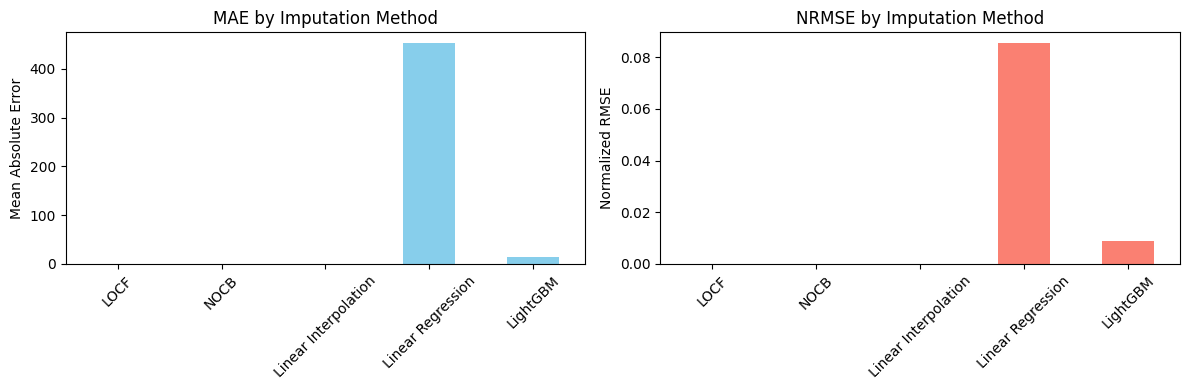

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df_performance["MAE"].plot(kind="bar", ax=axs[0], color="skyblue")
axs[0].set_title("MAE by Imputation Method")
axs[0].set_ylabel("Mean Absolute Error")
axs[0].set_xticklabels(df_performance.index, rotation=45)

df_performance["NRMSE"].plot(kind="bar", ax=axs[1], color="salmon")
axs[1].set_title("NRMSE by Imputation Method")
axs[1].set_ylabel("Normalized RMSE")
axs[1].set_xticklabels(df_performance.index, rotation=45)

plt.tight_layout()
plt.savefig(f"performance/figures/maxwell/error_{target_prefix}.png")
plt.show()

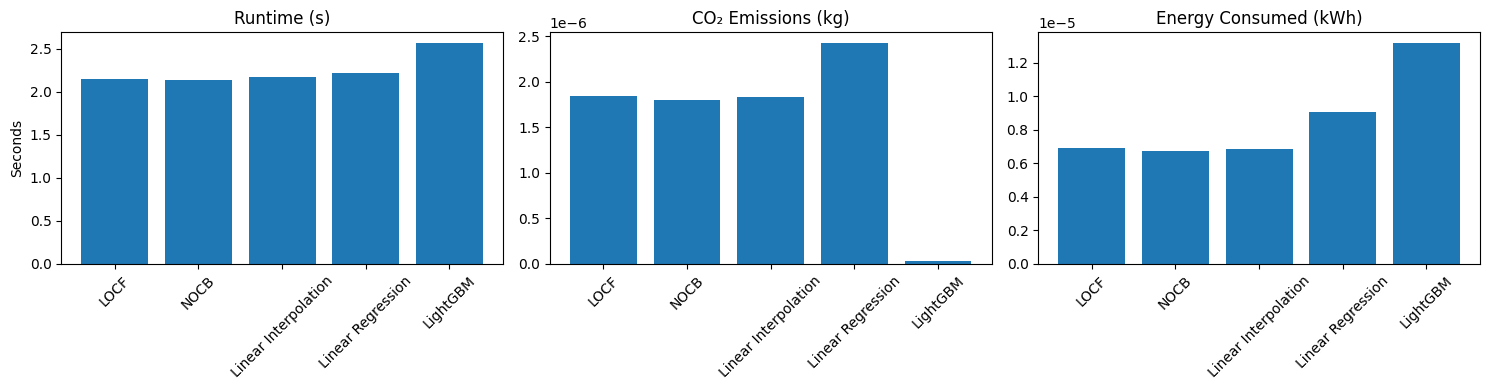

                      duration     emissions  energy_consumed
project_name                                                 
LOCF                  2.149838  1.841730e-06         0.000007
NOCB                  2.140826  1.802367e-06         0.000007
Linear Interpolation  2.165623  1.829632e-06         0.000007
Linear Regression     2.217223  2.419373e-06         0.000009
LightGBM              2.560971  3.124147e-08         0.000013


In [215]:
df_emission = pd.read_csv(f"performance/maxwell_codecarbon_{target_prefix}.csv")
df_emission_cleaned = df_emission[["project_name", "duration", "emissions", "energy_consumed"]]
df_emission_cleaned = df_emission_cleaned.set_index("project_name")

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].bar(df_emission_cleaned.index, df_emission_cleaned["duration"])
axs[0].set_title("Runtime (s)")
axs[0].set_ylabel("Seconds")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(df_emission_cleaned.index, df_emission_cleaned["emissions"])
axs[1].set_title("CO₂ Emissions (kg)")
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(df_emission_cleaned.index, df_emission_cleaned["energy_consumed"])
axs[2].set_title("Energy Consumed (kWh)")
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"performance/figures/maxwell/emissions_codecarbon_{target_prefix}.png")
plt.show()

print(df_emission_cleaned)

                      duration(s)  CO2_emissions(kg)  power_consumption(kWh)
project_name                                                                
LOCF                     0.770486       2.668848e-08            6.771716e-08
NOCB                     0.773023       2.676970e-08            6.792323e-08
Linear Interpolation     0.793398       2.748192e-08            6.973036e-08
Linear Regression        0.843654       2.935092e-08            7.447261e-08
LightGBM                 1.190183       4.212345e-08            1.068806e-07


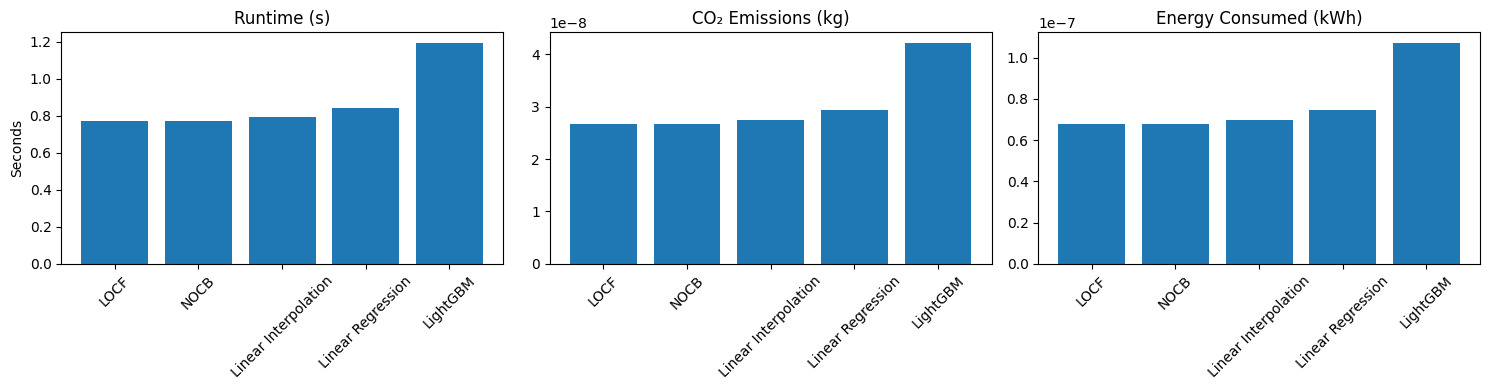

[codecarbon INFO @ 21:59:21] Energy consumed for RAM : 0.002137 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:22] Delta energy consumed for CPU with cpu_load : 0.000031 kWh, power : 7.593 W
[codecarbon INFO @ 21:59:22] Energy consumed for All CPU : 0.001242 kWh
[codecarbon INFO @ 21:59:22] 0.003379 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:36] Energy consumed for RAM : 0.002177 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:37] Delta energy consumed for CPU with cpu_load : 0.000020 kWh, power : 4.851000000000001 W
[codecarbon INFO @ 21:59:37] Energy consumed for All CPU : 0.001261 kWh
[codecarbon INFO @ 21:59:37] 0.003439 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:51] Energy consumed for RAM : 0.002218 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:52] Delta energy consumed for CPU with cpu_load : 0.000020 kWh, power : 4.848000000000001 W
[codecarbon INFO @ 21:59:52] Energy consumed for All CPU : 0.001281 kWh
[codecarbon INF

In [ ]:
# Plot eco2ai performance
df_emission = pd.read_csv(f"maxwell_eco2ai_{target_prefix}.csv")
df_emission_cleaned = df_emission[["project_name", "duration(s)", "CO2_emissions(kg)", "power_consumption(kWh)"]]
df_emission_cleaned = df_emission_cleaned.set_index("project_name")

print(df_emission_cleaned)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].bar(df_emission_cleaned.index, df_emission_cleaned["duration(s)"])
axs[0].set_title("Runtime (s)")
axs[0].set_ylabel("Seconds")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(df_emission_cleaned.index, df_emission_cleaned["CO2_emissions(kg)"])
axs[1].set_title("CO₂ Emissions (kg)")
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(df_emission_cleaned.index, df_emission_cleaned["power_consumption(kWh)"])
axs[2].set_title("Energy Consumed (kWh)")
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"performance/figures/maxwell/emissions_eco2ai_{target_prefix}.png")
plt.show()